# qPCR AT8

In [2]:
import pandas as pd, numpy as np, scipy, re, seaborn as sns, random, pysam, sklearn, glob
sns.set()
import itertools as it

from collections import defaultdict
from scipy import stats, integrate, cluster
from scipy.stats import entropy, spearmanr, ttest_ind, zscore

import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3, venn3_circles, venn3_unweighted

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/Mojito/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['entropy', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Files

In [25]:
qpcr = pd.read_excel('qPCR_values.xlsx')
infoc = pd.read_csv('../all_wocnt_all_info.csv', sep=',')
infoc['SampleName']=['{}-{:03d}'.format(_.split('-')[0], int(_.split('-')[1])) if 'SLI' in _ else _ for _ in infoc['SampleName']]
infoc['SampleName'] = [_.replace('-','_') for _ in infoc['SampleName'].tolist()]
infoc = infoc[~infoc['AT8'].isnull()]
qpcr = qpcr[~qpcr['AT8 Density - Crest'].isnull()]
qpcr['Case'] = [_.replace('-','_') for _ in qpcr['Case'].tolist()]
print('qPCR samples: ',len(qpcr),'\t RNAseq samples: ',len(infoc))
print('qPCR/RNAseq intersection: ',len(set(qpcr['Case']).intersection(set(infoc['SampleName']))))
print('qPCR/RNAseq difference: ',len(set(qpcr['Case']).difference(set(infoc['SampleName']))))

#inter = pd.merge(qpcr,infoc[list(infoc)[:9]], left_on='Case', right_on='SampleName')
inter_id = list(set(qpcr['Case']).intersection(set(infoc['SampleName'])))
difr_id = list(set(qpcr['Case']).difference(set(infoc['SampleName'])))

qpcr = qpcr.rename(columns={"TNFa": "TNF", "Aqp4": "AQP4", "IL1b":"IL1B","IL-6":"IL6","TGFb1":"TGFB1","IL-10":"IL10",
                            "NRF2":"NFE2L2","C1qA":"C1QA","iNOS":"NOS2","IFNg":"IFNG","IL1a":"IL1A","IL-8":"CXCL8",
                            "HLA-DRA":"HLA_DRA","PSD-95":"DLG4","AT8 Density - Sulcus":"AT8_sulcus",
                            "AT8 Density - Crest":"AT8_crest","Comorbid pathology":"Comorbid"})

# Change AT8 counts to log counts
qpcr['AT8_crest'] = np.log10(qpcr['AT8_crest'])
info_cols = list(qpcr)[:5] + list(qpcr)[-2:]
qpcr_genes = list(qpcr)[5:-2]
qpcr['Status']=['CTEM' if _ == 'Mild CTE' else 'RHIN' if _ == 'RHI without CTE' else 'CTES' for _ in qpcr['pathgroup'].tolist()]

inter = qpcr[qpcr['Case'].isin(inter_id)]

print('qPCR CTES/CTEM/RHIN: ',len(qpcr[qpcr['Status']=='CTES']),len(qpcr[qpcr['Status']=='CTEM']),len(qpcr[qpcr['Status']=='RHIN']))
print('mRNASeq CTES/CTEM/RHIN: ',len(infoc[infoc['Status']=='CTES']),len(infoc[infoc['Status']=='CTEM']),len(infoc[infoc['Status']=='RHIN']))
print('Inter CTES/CTEM/RHIN: ',len(inter[inter['Status']=='CTES']),len(inter[inter['Status']=='CTEM']),len(inter[inter['Status']=='RHIN']))

pd.DataFrame({'Samples':['qPCR','mRNAseq','qPCR/mRNASeq intersection'],'CTES':[70,51,37],
              'CTEM':[19,10,9],'RHIN':[13,9,8],'Missing AT8':[4,6,'-'],'Total':[106,76,54]}, 
             columns=['Samples','CTES','CTEM','RHIN','Missing AT8','Total'])

qPCR samples:  102 	 RNAseq samples:  70
qPCR/RNAseq intersection:  54
qPCR/RNAseq difference:  48
qPCR CTES/CTEM/RHIN:  70 19 13
mRNASeq CTES/CTEM/RHIN:  51 10 9
Inter CTES/CTEM/RHIN:  37 9 8


Samples  CTES  CTEM  RHIN Missing AT8  Total
0                       qPCR    70    19    13           4    106
1                    mRNAseq    51    10     9           6     76
2  qPCR/mRNASeq intersection    37     9     8           -     54

### Use cte-ad if its from the mrna seq data

In [26]:
q_cnts = qpcr[['Case']+qpcr_genes]
q_cnts = q_cnts.set_index('Case')
q_cnts.index.name = None
q_cnts = q_cnts.multiply(10000)
q_cnts.index.name = 'Gene'
#q_cnts = qpcr_cnts.fillna(0)
cnt_at8 = pd.merge(qpcr[['Case','RIN','AT8_crest','Status','age']],q_cnts,left_on='Case',right_index=True)

In [27]:
#cnt_at8.to_csv('qPCR_values_inter.csv',index=False)
ct = cnt_at8[list(cnt_at8)[5:]].T
ct[ct.isnull().any(axis=1)]

0         1         2         4         5         6         7    \
TNF    0.000100  0.000310  0.000440  0.000331  0.000323  0.000028  0.000143   
BDNF   0.018629  0.007079  0.013780  0.010144  0.038760  0.003715  0.002954   
TGFB1  0.048520  0.045649  0.155040  0.062271  0.067112  0.010626  0.011294   
IL10   0.001189  0.000189  0.003873  0.000489  0.002027  0.000121  0.000082   
IL13   0.000312  0.000047  0.000036  0.000076  0.000229  0.000098  0.000110   
TREM2  0.029131  0.026236  0.044308  0.056395  0.046705  0.007243  0.006541   
IFNG   0.000119  0.000045       NaN  0.000045  0.000073  0.000018       NaN   
IL1A   0.000399  0.000614  0.002559  0.000844  0.002494  0.000189  0.000101   
CXCL8  0.005786  0.008697  0.014913  0.001509  0.006776  0.001471  0.002246   
XPO1   0.038466  0.015385  0.016218  0.023047  0.029354  0.118152  0.121221   
IL4R   0.034571  0.033232  0.175521  0.022682  0.057182  0.058668  0.051930   
KCNA3  0.056278  0.007898  0.019021  0.015665  0.035200  0.032525  0.024209   
MMP2   0.006952  0.006248  0.012983  0.008500  0.007446  0.137139  0.012308   
MMP9   0.002016  0.000706  0.004312  0.005550  0.001106  0.080980  0.001066   
ACTA2  0.306660  0.044989  0.065413  0.024159  0.282185  0.087457  0.076347   
CSPG4  0.101793  0.073186  0.065413  0.048318  0.074156  0.083315  0.071879   
FKBP5  0.256621  0.183101  0.412570  0.107971  0.090855  0.719822  0.814910   
TLR4   0.007703  0.003539  0.004244  0.008126  0.006809  0.006665  0.009650   
CCL2   0.015482  0.005766  0.054587  0.005211  0.058222  0.036240  0.025696   

            8         9           10   ...       98        99        100  \
TNF    0.000163       NaN    0.000842  ...  0.001098  0.000079  0.000090   
BDNF   0.011897  0.006618    0.042005  ...  0.052509  0.010032  0.009710   
TGFB1  0.016410  0.010328    0.019746  ...  0.093994  0.032911  0.025947   
IL10   0.001045  0.000102    0.002348  ...  0.002202  0.000212  0.000494   
IL13   0.000041       NaN    0.000683  ...  0.000165  0.000107  0.000155   
TREM2  0.078766  0.006420    0.042977  ...  0.225580  0.010371  0.023336   
IFNG   0.000023       NaN    0.000112  ...  0.000299  0.000152  0.000043   
IL1A   0.002155  0.000193    0.004137  ...  0.004336  0.000487  0.000472   
CXCL8  0.004160  0.002978    0.006786  ...  0.003741  0.001915  0.003770   
XPO1   0.326626  0.044247    0.656430  ...  0.086492  0.036290  0.039057   
IL4R   0.112634  0.081487   58.109913  ...  0.042239  0.024735  0.019300   
KCNA3  0.078059  0.042063  134.150849  ...  0.078330  0.023336  0.035691   
MMP2   0.030432  0.008703    0.459047  ...  0.024976  0.002322  0.004114   
MMP9   0.018373  0.000332    0.038922  ...  0.000790  0.004732  0.000591   
ACTA2  0.375976  0.086552         NaN  ...  1.035059  0.030664  0.115560   
CSPG4  0.176374  0.130102    0.948495  ...  0.123169  0.037989  0.055773   
FKBP5  1.293888  0.606136         NaN  ...  0.312670  0.173705  0.251689   
TLR4   0.016206  0.003282    0.026273  ...  0.016017  0.002215  0.005380   
CCL2   0.087882  0.011357   26.349659  ...  0.092572  0.026182  0.003201   

            101       103       104       105       106       107       108  
TNF    0.000304  0.000811  0.000311  0.000127  0.000969  0.000109  0.000402  
BDNF   0.010932  0.011232  0.015343  0.010299  0.029131  0.006952  0.027332  
TGFB1  0.031244  0.033002  0.045839  0.042268  0.034237  0.022983  0.026346  
IL10   0.000688  0.000733  0.000571  0.000772  0.000861  0.000423  0.000580  
IL13   0.000070  0.000061  0.000175  0.000058  0.000321  0.000164  0.000191  
TREM2  0.061244  0.049573  0.063536  0.057860  0.061884  0.025643  0.013543  
IFNG   0.000039       NaN  0.000049  0.000067  0.000193  0.000147       NaN  
IL1A   0.000672  0.001440  0.000332  0.000638  0.001404  0.000411  0.001084  
CXCL8  0.004805  0.003739  0.006036  0.001200  0.003646  0.003481  0.005690  
XPO1   0.020944  0.018929  0.027369  0.009412  0.024462  0.025501  0.032661  
IL4R   0.019353  0.032167  0.046964  0.018398  0.007

In [28]:
ct.isnull().sum(axis=1)

TNF         2
GFAP        0
AQP4        0
IL1B        0
HLA_DRA     0
IL6         0
ICAM1       0
BDNF        1
IGF1        0
TGFB1       1
IL10        1
NFE2L2      0
NLRP3       0
IL13        6
C1QA        0
NOS2        0
CD68        0
TREM2       1
IFNG       37
IL1A        1
CXCL8       1
DLG4        0
XPO1        1
IL4R        1
KCNA3       1
CD33        0
CD36        0
MMP2        4
MMP9        6
ACTA2       2
CSPG4       1
FKBP5       3
TLR4        1
CCL2        1
dtype: int64

### Outliers

/Users/Mojito/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


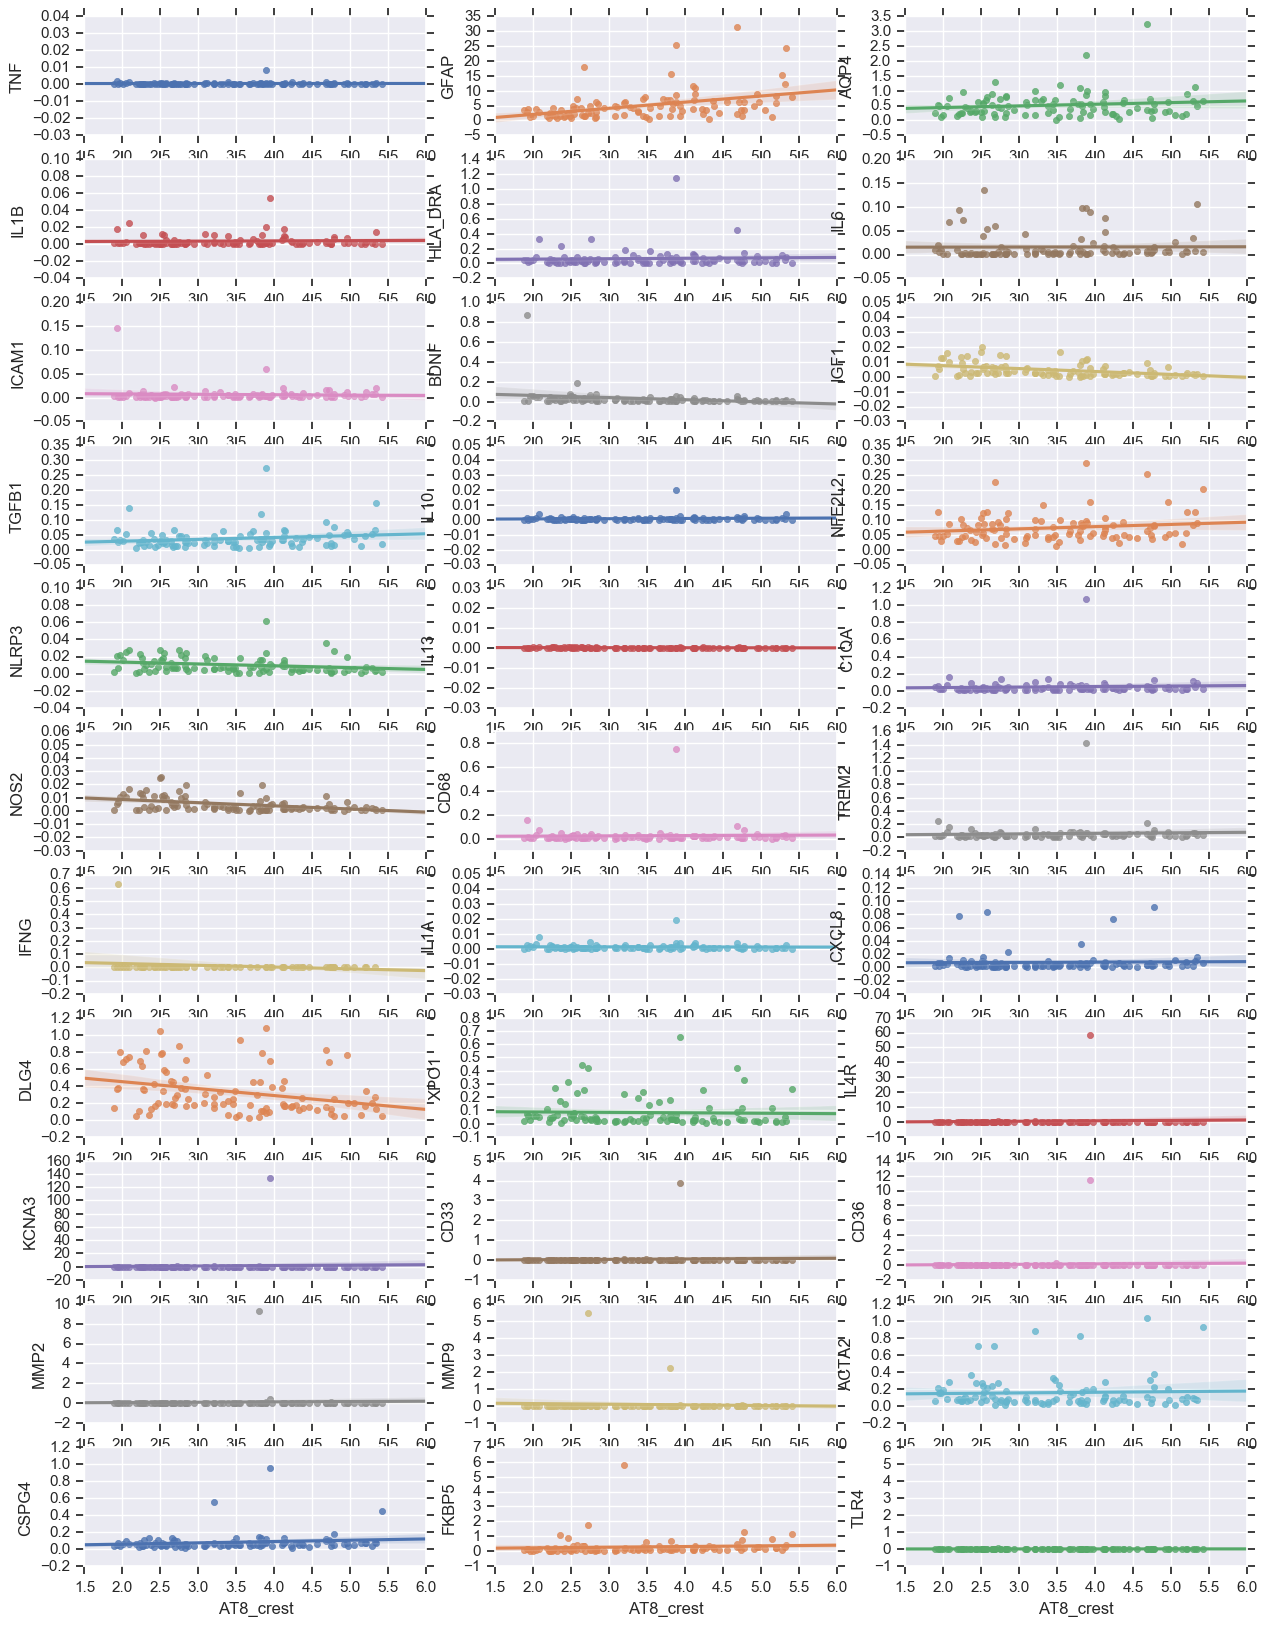

In [29]:
f, axs = plt.subplots(11,3, figsize=(15,20))
axs = axs.flatten()
for ax, i in zip(axs, range(len(qpcr_genes))):
    gene = qpcr_genes[i]
    sns.regplot(x='AT8_crest', y=gene, data=cnt_at8, ax=ax)   
#plt.savefig('qPCR_Log10_AT8crest.png', bbox_inches='tight')

In [30]:
outliers = cnt_at8[(cnt_at8['BDNF']>0.8)|(cnt_at8['C1QA']>1)|(cnt_at8['CD68']>0.5)|(cnt_at8['TREM2']>1)|
                   (cnt_at8['IFNG']>0.5)|(cnt_at8['IL4R']>50)|(cnt_at8['KCNA3']>100)|(cnt_at8['CD33']>2)|
                   (cnt_at8['CD36']>10)|(cnt_at8['MMP2']>5)|(cnt_at8['MMP9']>5)|(cnt_at8['FKBP5']>5)]

In [31]:
print(outliers['Case'])

10     K_0178
32    SLI_105
33    SLI_109
72     K_0084
77     K_0139
80     K_0148
82     K_0151
Name: Case, dtype: object


In [32]:
# ALL, remove outliers
cnt_at8_no = cnt_at8[~cnt_at8['Case'].isin(outliers['Case'])]
ct_rhi = cnt_at8_no[cnt_at8_no['Status']!='CTES']
ctes = cnt_at8_no[cnt_at8_no['Status']=='CTES']
infoco = infoc[~infoc['SampleName'].isin(outliers['Case'])]
inter = cnt_at8_no[cnt_at8_no['Case'].isin(inter_id)]
print(len(outliers),len(cnt_at8),len(cnt_at8_no),len(infoco),len(ct_rhi),len(ctes),len(inter))

print('qPCR CTES/CTEM/RHIN: ',len(cnt_at8_no[cnt_at8_no['Status']=='CTES']),len(cnt_at8_no[cnt_at8_no['Status']=='CTEM']),len(cnt_at8_no[cnt_at8_no['Status']=='RHIN']))
print('mRNASeq CTES/CTEM/RHIN: ',len(infoco[infoco['Status']=='CTES']),len(infoco[infoco['Status']=='CTEM']),len(infoco[infoco['Status']=='RHIN']))
print('Inter CTES/CTEM/RHIN: ',len(inter[inter['Status']=='CTES']),len(inter[inter['Status']=='CTEM']),len(inter[inter['Status']=='RHIN']))


pd.DataFrame({'Samples':['qPCR','mRNAseq','qPCR/mRNASeq intersection'],'CTES':[65,49,35],
              'CTEM':[17,10,9],'RHIN':[13,9,8],'Total':[95,68,52]}, 
             columns=['Samples','CTES','CTEM','RHIN','Total'])

7 102 95 68 30 65 52
qPCR CTES/CTEM/RHIN:  65 17 13
mRNASeq CTES/CTEM/RHIN:  49 10 9
Inter CTES/CTEM/RHIN:  35 9 8


Samples  CTES  CTEM  RHIN  Total
0                       qPCR    65    17    13     95
1                    mRNAseq    49    10     9     68
2  qPCR/mRNASeq intersection    35     9     8     52

/Users/Mojito/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


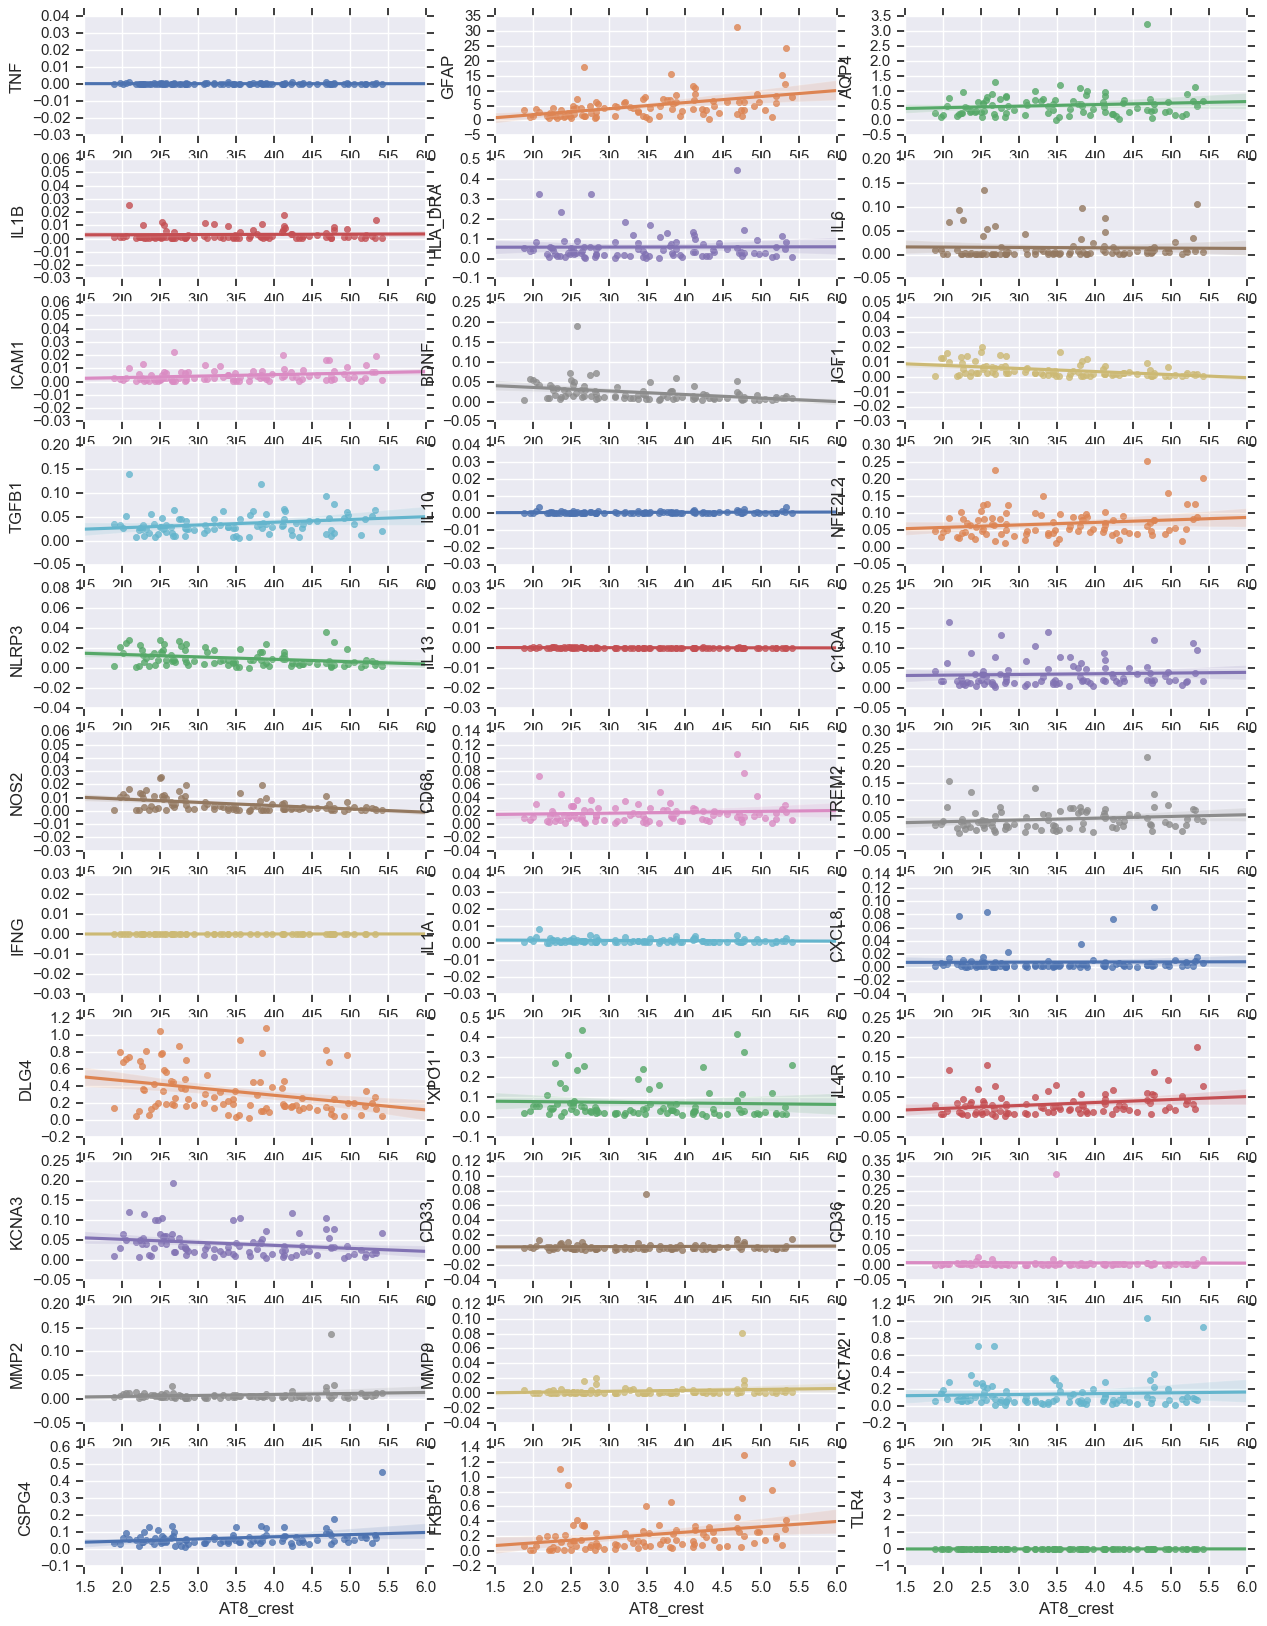

In [33]:
f, axs = plt.subplots(11,3, figsize=(15,20))
axs = axs.flatten()
for ax, i in zip(axs, range(len(qpcr_genes))):
    gene = qpcr_genes[i]
    sns.regplot(x='AT8_crest', y=gene, data=cnt_at8_no, ax=ax)   
#plt.savefig('qPCR_Log10_AT8crest_removeoutliers.png', bbox_inches='tight')

### Linear Reg RNAseq

In [12]:
# Intersect RNAseq
inter = cnt_at8_no[cnt_at8_no['Case'].isin(inter_id)]
inct_rhi = inter[inter['Status']!='CTES']
inctes = inter[inter['Status']=='CTES']

print('CTEM/RHIN: ',len(ct_rhi),'\t CTES: ',len(ctes),'\t CTEM/RHIN inter: ',len(inct_rhi),'\t CTES inter: ',len(inctes))

def LR(cov,df):
    res_all = pd.DataFrame()
    for gene in qpcr_genes:
        eqt = ' ~ ' + cov
        results = smf.ols(gene+eqt, data=df[[gene]+['RIN','age','AT8_crest']]).fit()
#    results = smf.ols(gene+' ~ RIN + age + AT8_crest', data=inctes[[gene]+['RIN','age','AT8_crest']]).fit()
#        print(gene,results.params,results.tvalues,results.pvalues)
        res_df = pd.DataFrame(pd.concat([results.params,results.tvalues,results.pvalues],axis=0)).T
        if cov != 'AT8_crest':
            res_df.columns = ['Intercept_L2FC','RIN_L2FC','age_L2FC','AT8_L2FC',
                              'Intercept_tval','RIN_tval','age_tval','AT8_tval',
                              'Intercept_pval','RIN_pval','age_pval','AT8_pval']
        if cov == 'AT8_crest':
            res_df.columns = ['Intercept_L2FC', 'AT8_L2FC','Intercept_tval','AT8_tval','Intercept_pval','AT8_pval']
        res_df['rsquared'] = results.rsquared
        res_df['gene'] = gene
        res_df = res_df[list(res_df)[-1:]+list(res_df)[:-1]]
        res_all = pd.concat([res_all,res_df],axis=0)
    res_all = res_all.reset_index(drop=True)
    if gene == 'CCL2':
        print(results.summary())
    return res_all
#res_all.to_csv('qPCR_CTEM_RHIN_inter_AT8_Lreg.csv', index=False)

CTEM/RHIN:  30 	 CTES:  65 	 CTEM/RHIN inter:  17 	 CTES inter:  35


In [13]:
LR_RAAT8_all = [LR('RIN + age + AT8_crest',ct_rhi),LR('RIN + age + AT8_crest',ctes)]
LR_RAAT8_inter = [LR('RIN + age + AT8_crest', inct_rhi),LR('RIN + age + AT8_crest',inctes)]
LR_AT8_all = [LR('AT8_crest',ct_rhi),LR('AT8_crest',ctes)]
LR_AT8_inter = [LR('AT8_crest',inct_rhi),LR('AT8_crest',inctes)]

LR_all = LR_RAAT8_all + LR_RAAT8_inter + LR_AT8_all + LR_AT8_inter
renames = []
for a in ['qpcr_RAAT8_all','qpcr_RAAT8_inter']:
    for b in ['CTEM_RHIN_','CTES_']:
        renames += [a+'_'+b]
for a in ['qpcr_AT8_all','qpcr_AT8_inter']:
    for b in ['CTEM_RHIN_','CTES_']:
        renames += [a+'_'+b]

                            OLS Regression Results                            
Dep. Variable:                   CCL2   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                 -0.053
Method:                 Least Squares   F-statistic:                    0.5163
Date:                Tue, 31 Mar 2020   Prob (F-statistic):              0.675
Time:                        03:47:01   Log-Likelihood:                 28.731
No. Observations:                  30   AIC:                            -49.46
Df Residuals:                      26   BIC:                            -43.86
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0162      0.156     -0.104      0.9

/Users/Mojito/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                   CCL2   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     1.961
Date:                Tue, 31 Mar 2020   Prob (F-statistic):              0.170
Time:                        03:47:02   Log-Likelihood:                 39.889
No. Observations:                  17   AIC:                            -71.78
Df Residuals:                      13   BIC:                            -68.45
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0010      0.059     -0.017      0.9

/Users/Mojito/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                   CCL2   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.066
Method:                 Least Squares   F-statistic:                   0.01109
Date:                Tue, 31 Mar 2020   Prob (F-statistic):              0.918
Time:                        03:47:05   Log-Likelihood:                 36.723
No. Observations:                  17   AIC:                            -69.45
Df Residuals:                      15   BIC:                            -67.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0218      0.056      0.392      0.7

In [14]:
df = LR_all[0]
df.columns = list(df)[:1] + [renames[0]+_ for _ in list(df)[1:]]

for i in range(len(LR_all)-1):
    ndf = LR_all[i+1]
    ndf.columns = list(ndf)[:1] + [renames[i+1]+_ for _ in list(ndf)[1:]]
    df = pd.merge(df,ndf, on='gene')

In [15]:
#df.to_csv('qpcr_ALL_linear_reg.csv',index=False)

## Compare L2FC

In [16]:
at8_DE = pd.read_csv('all_DE_AT8_annot.csv',sep=',')
keeps = [_ for _ in list(at8_DE) if "CTEM_RHIN" in _ or "CTE_34" in _]
keeps = list(at8_DE)[:2]+[_ for _ in keeps if "lfcSE" not in _ and "stat" not in _]
at8_DE["Gene name"].replace({"HLA-DRA": "HLA_DRA"}, inplace=True)
at8_DE = at8_DE[at8_DE['Gene name'].isin(qpcr_genes)][keeps]
print('Genes not in mRNASeq set: ',set(qpcr_genes).difference(set(at8_DE['Gene name'])))

df.columns = ['Gene name'] + list(df)[1:]
df_keep = list(df)[:1] +[_ for _ in list(df) if 'AT8_L2FC' in _ or 'AT8_pval' in _ ]
df = df[df_keep]

Genes not in mRNASeq set:  {'IL10', 'IFNG'}


In [17]:
merged = pd.merge(at8_DE, df, on='Gene name')
merged.columns

Index(['Gene name', 'Name', 'CTEM_RHIN_all_DE_AT8_baseMean',
       'CTEM_RHIN_all_DE_AT8_L2FC', 'CTEM_RHIN_all_DE_AT8_pvalue',
       'CTEM_RHIN_all_DE_AT8_padj', 'CTE_34_all_DE_AT8_baseMean',
       'CTE_34_all_DE_AT8_L2FC', 'CTE_34_all_DE_AT8_pvalue',
       'CTE_34_all_DE_AT8_padj', 'qpcr_RAAT8_all_CTEM_RHIN_AT8_L2FC',
       'qpcr_RAAT8_all_CTEM_RHIN_AT8_pval', 'qpcr_RAAT8_all_CTES_AT8_L2FC',
       'qpcr_RAAT8_all_CTES_AT8_pval', 'qpcr_RAAT8_inter_CTEM_RHIN_AT8_L2FC',
       'qpcr_RAAT8_inter_CTEM_RHIN_AT8_pval', 'qpcr_RAAT8_inter_CTES_AT8_L2FC',
       'qpcr_RAAT8_inter_CTES_AT8_pval', 'qpcr_AT8_all_CTEM_RHIN_AT8_L2FC',
       'qpcr_AT8_all_CTEM_RHIN_AT8_pval', 'qpcr_AT8_all_CTES_AT8_L2FC',
       'qpcr_AT8_all_CTES_AT8_pval', 'qpcr_AT8_inter_CTEM_RHIN_AT8_L2FC',
       'qpcr_AT8_inter_CTEM_RHIN_AT8_pval', 'qpcr_AT8_inter_CTES_AT8_L2FC',
       'qpcr_AT8_inter_CTES_AT8_pval'],
      dtype='object')

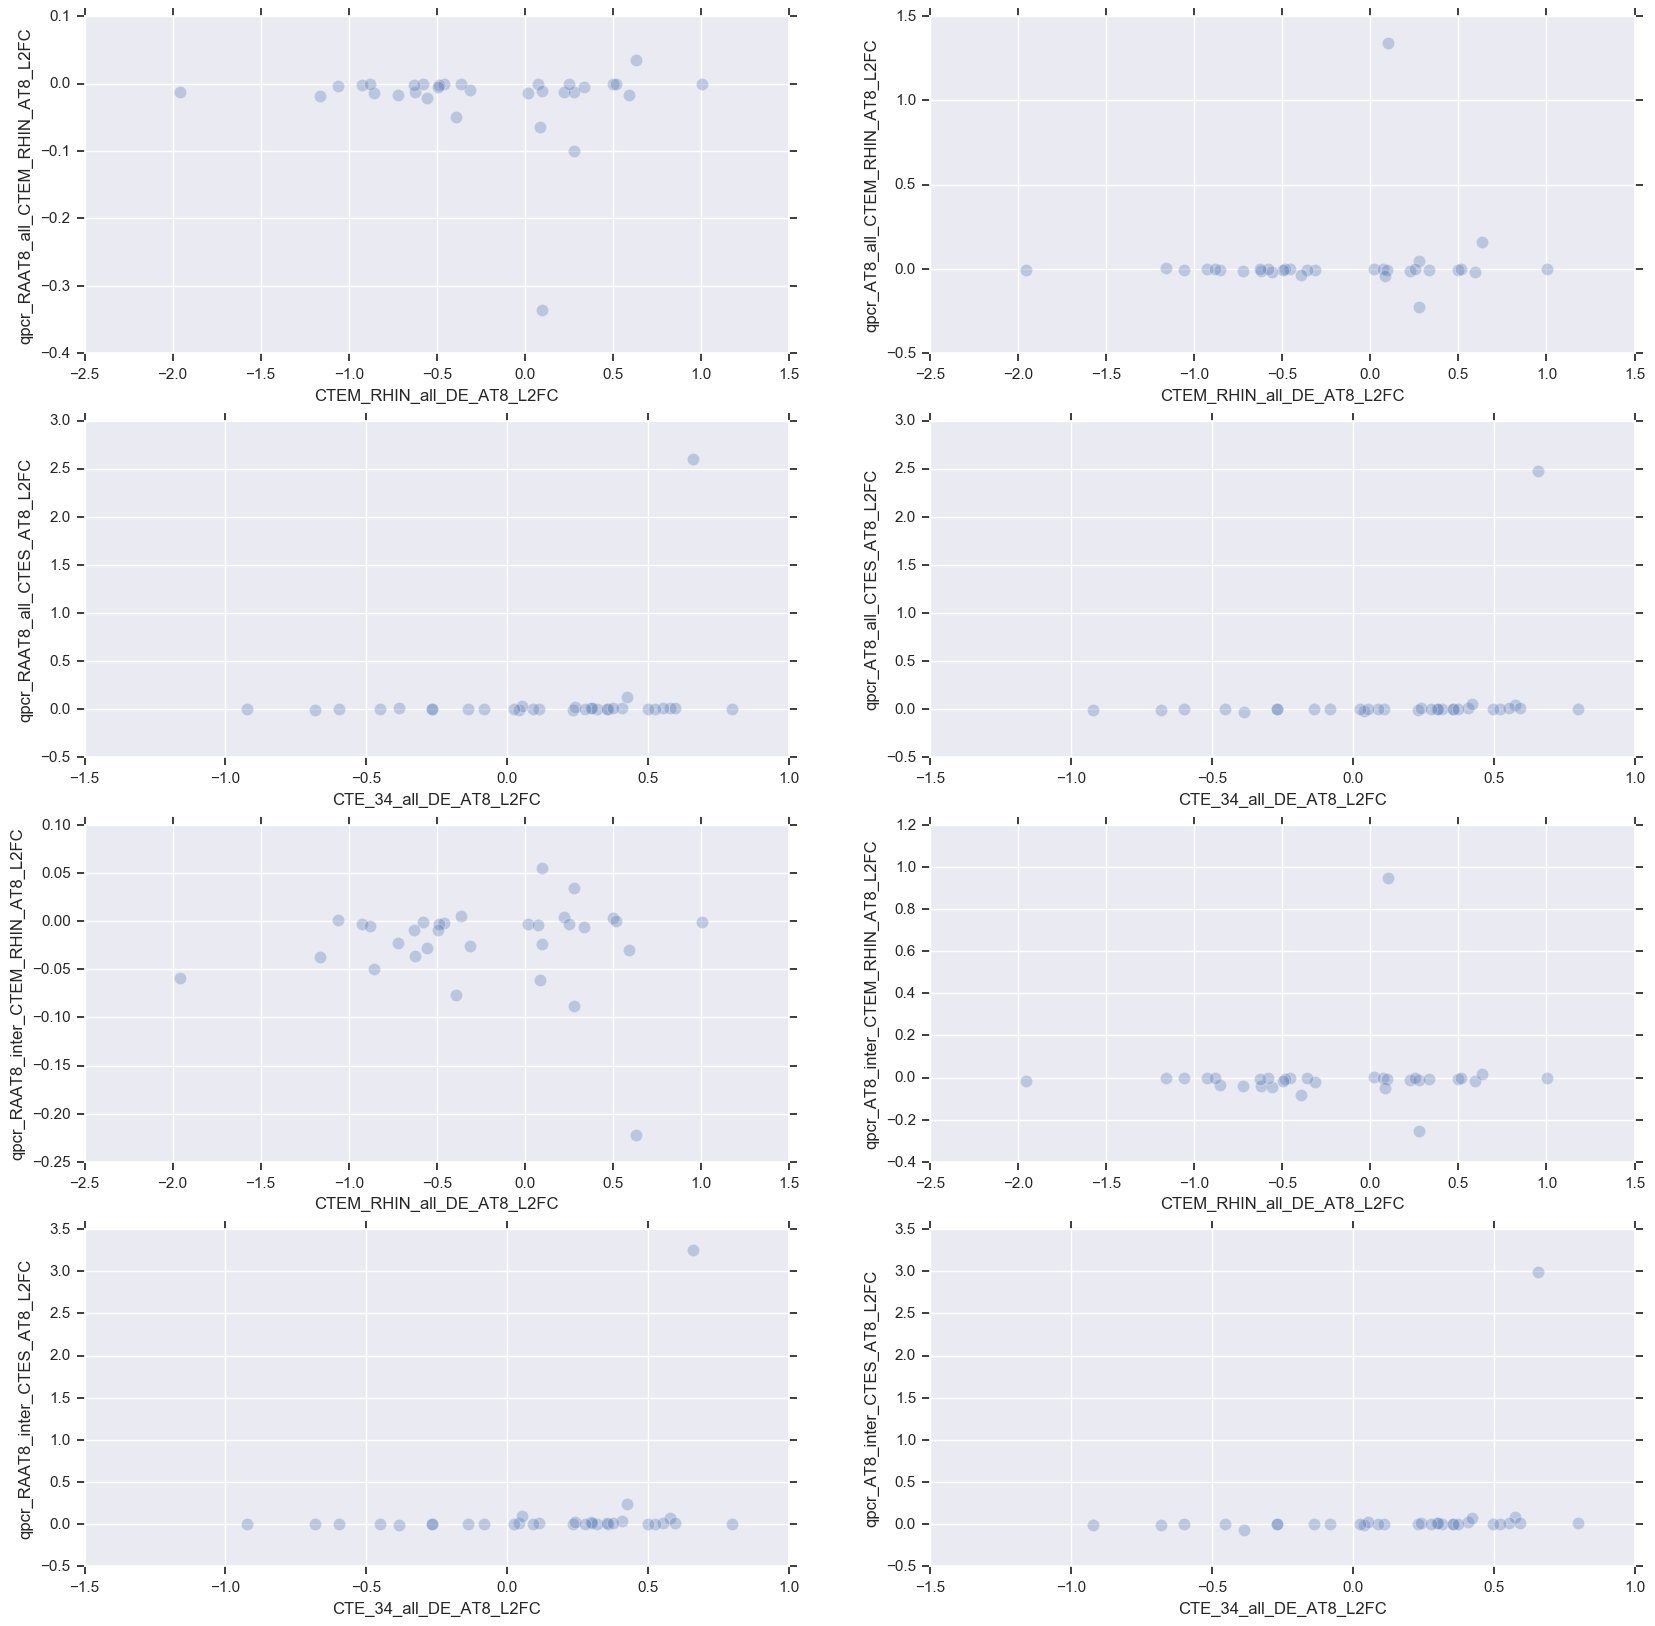

In [18]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.subplot(4, 2, 1)
sns.scatterplot(merged['CTEM_RHIN_all_DE_AT8_L2FC'],merged['qpcr_RAAT8_all_CTEM_RHIN_AT8_L2FC'], alpha=0.3, s=80)
plt.subplot(4, 2, 2)
sns.scatterplot(merged['CTEM_RHIN_all_DE_AT8_L2FC'],merged['qpcr_AT8_all_CTEM_RHIN_AT8_L2FC'], alpha=0.3, s=80)
plt.subplot(4, 2, 3)
sns.scatterplot(merged['CTE_34_all_DE_AT8_L2FC'],merged['qpcr_RAAT8_all_CTES_AT8_L2FC'], alpha=0.3, s=80)
plt.subplot(4, 2, 4)
sns.scatterplot(merged['CTE_34_all_DE_AT8_L2FC'],merged['qpcr_AT8_all_CTES_AT8_L2FC'], alpha=0.3, s=80)
plt.subplot(4, 2, 5)
sns.scatterplot(merged['CTEM_RHIN_all_DE_AT8_L2FC'],merged['qpcr_RAAT8_inter_CTEM_RHIN_AT8_L2FC'], alpha=0.3, s=80)
plt.subplot(4, 2, 6)
sns.scatterplot(merged['CTEM_RHIN_all_DE_AT8_L2FC'],merged['qpcr_AT8_inter_CTEM_RHIN_AT8_L2FC'], alpha=0.3, s=80)
plt.subplot(4, 2, 7)
sns.scatterplot(merged['CTE_34_all_DE_AT8_L2FC'],merged['qpcr_RAAT8_inter_CTES_AT8_L2FC'], alpha=0.3, s=80)
plt.subplot(4, 2, 8)
sns.scatterplot(merged['CTE_34_all_DE_AT8_L2FC'],merged['qpcr_AT8_inter_CTES_AT8_L2FC'], alpha=0.3, s=80)



In [19]:
########## Matching samples
CR = pd.read_csv('CTEM_RHIN_qpcr_DE_AT8_annot.csv', sep=',')
CTES = pd.read_csv('CTE_34_qpcr_DE_AT8_annot.csv', sep=',')
CR.columns = ['Gene name', 'Name'] + ['CTEM_RHIN_'+_ for _ in list(CR)[2:]]
CTES.columns = ['Gene name', 'Name'] + ['CTES_'+_ for _ in list(CTES)[2:]]
at8_DE = pd.merge(CR, CTES, on=['Gene name', 'Name'])

keeps = list(at8_DE)[:2]+[_ for _ in list(at8_DE)[2:] if "lfcSE" not in _ and "stat" not in _ and "Seq_Batch" not in _]
at8_DE["Gene name"].replace({"HLA-DRA": "HLA_DRA"}, inplace=True)
at8_DE = at8_DE[at8_DE['Gene name'].isin(qpcr_genes)][keeps]
print('Genes not in mRNASeq set: ',set(qpcr_genes).difference(set(at8_DE['Gene name'])))

df.columns = ['Gene name'] + list(df)[1:]
df_keep = list(df)[:1] +[_ for _ in list(df) if 'AT8_L2FC' in _ or 'AT8_pval' in _ ]
df = df[df_keep]

Genes not in mRNASeq set:  {'IL10', 'IFNG'}


In [20]:
merged = pd.merge(at8_DE, df, on='Gene name')
merged.columns

Index(['Gene name', 'Name', 'CTEM_RHIN_baseMean',
       'CTEM_RHIN_agedeath__log2FoldChange', 'CTEM_RHIN_agedeath__pvalue',
       'CTEM_RHIN_agedeath__padj', 'CTEM_RHIN_RIN__log2FoldChange',
       'CTEM_RHIN_RIN__pvalue', 'CTEM_RHIN_RIN__padj',
       'CTEM_RHIN_AT8__log2FoldChange', 'CTEM_RHIN_AT8__pvalue',
       'CTEM_RHIN_AT8__padj', 'CTES_baseMean', 'CTES_agedeath__log2FoldChange',
       'CTES_agedeath__pvalue', 'CTES_agedeath__padj',
       'CTES_RIN__log2FoldChange', 'CTES_RIN__pvalue', 'CTES_RIN__padj',
       'CTES_AT8__log2FoldChange', 'CTES_AT8__pvalue', 'CTES_AT8__padj',
       'qpcr_RAAT8_all_CTEM_RHIN_AT8_L2FC',
       'qpcr_RAAT8_all_CTEM_RHIN_AT8_pval', 'qpcr_RAAT8_all_CTES_AT8_L2FC',
       'qpcr_RAAT8_all_CTES_AT8_pval', 'qpcr_RAAT8_inter_CTEM_RHIN_AT8_L2FC',
       'qpcr_RAAT8_inter_CTEM_RHIN_AT8_pval', 'qpcr_RAAT8_inter_CTES_AT8_L2FC',
       'qpcr_RAAT8_inter_CTES_AT8_pval', 'qpcr_AT8_all_CTEM_RHIN_AT8_L2FC',
       'qpcr_AT8_all_CTEM_RHIN_AT8_pval', 'qpcr_AT8_

(-1e-05, 1e-05)

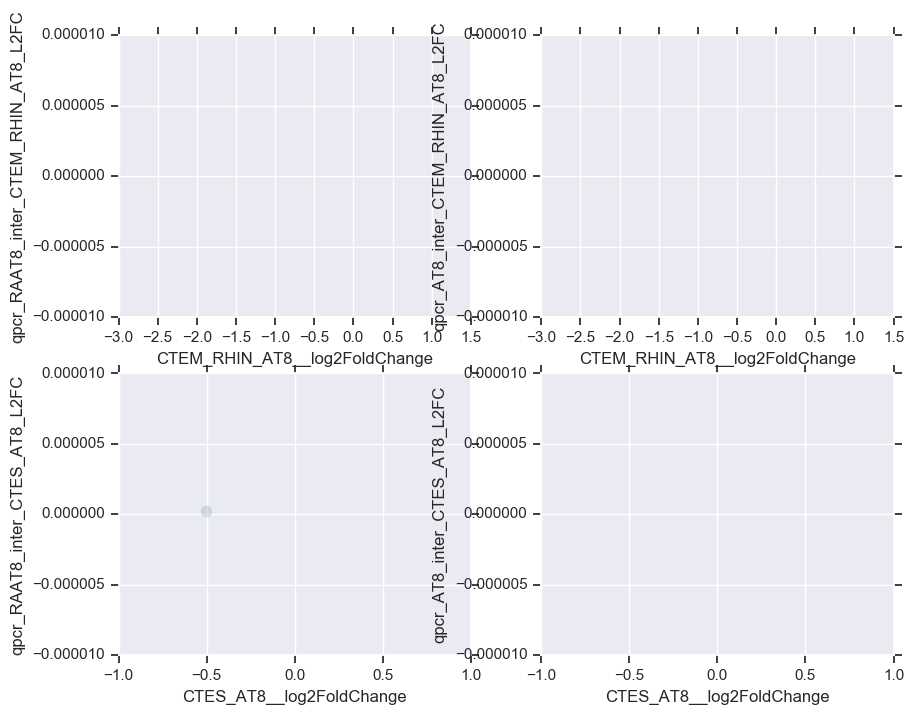

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.subplot(2, 2, 1)
sns.scatterplot(merged['CTEM_RHIN_AT8__log2FoldChange'],merged['qpcr_RAAT8_inter_CTEM_RHIN_AT8_L2FC'], alpha=0.2, s=75)
plt.ylim(-0.00001,0.00001)
plt.subplot(2, 2, 2)
sns.scatterplot(merged['CTEM_RHIN_AT8__log2FoldChange'],merged['qpcr_AT8_inter_CTEM_RHIN_AT8_L2FC'], alpha=0.2, s=75)
plt.ylim(-0.00001,0.00001)
plt.subplot(2, 2, 3)
sns.scatterplot(merged['CTES_AT8__log2FoldChange'],merged['qpcr_RAAT8_inter_CTES_AT8_L2FC'], alpha=0.2, s=75)
plt.ylim(-0.00001,0.00001)
plt.subplot(2, 2, 4)
sns.scatterplot(merged['CTES_AT8__log2FoldChange'],merged['qpcr_AT8_inter_CTES_AT8_L2FC'], alpha=0.2, s=75)
plt.ylim(-0.00001,0.00001)

### Spearman correlation

In [22]:
print(spearmanr(merged['CTEM_RHIN_AT8__log2FoldChange'],merged['qpcr_RAAT8_inter_CTEM_RHIN_AT8_L2FC']))
print(spearmanr(merged['CTES_AT8__log2FoldChange'],merged['qpcr_RAAT8_inter_CTES_AT8_L2FC']))

print(spearmanr(merged['CTEM_RHIN_AT8__log2FoldChange'],merged['qpcr_AT8_inter_CTEM_RHIN_AT8_L2FC']))
print(spearmanr(merged['CTES_AT8__log2FoldChange'],merged['qpcr_AT8_inter_CTES_AT8_L2FC']))

SpearmanrResult(correlation=0.22397360703812316, pvalue=0.2178346634986326)
SpearmanrResult(correlation=0.7573313782991201, pvalue=5.23467758962329e-07)
SpearmanrResult(correlation=0.1066715542521994, pvalue=0.5611867932289296)
SpearmanrResult(correlation=0.7895894428152492, pvalue=7.794885515446271e-08)


### Size points

In [190]:
sp = merged[['Gene name', 'Name', 'CTEM_RHIN_AT8__log2FoldChange','CTEM_RHIN_AT8__padj',
            'CTES_AT8__log2FoldChange','CTES_AT8__padj',
            'qpcr_RAAT8_inter_CTEM_RHIN_AT8_L2FC','qpcr_RAAT8_inter_CTES_AT8_L2FC',
            'qpcr_AT8_inter_CTEM_RHIN_AT8_L2FC','qpcr_AT8_inter_CTES_AT8_L2FC',
            'qpcr_RAAT8_inter_CTEM_RHIN_AT8_pval','qpcr_RAAT8_inter_CTES_AT8_pval',
            'qpcr_AT8_inter_CTEM_RHIN_AT8_pval','qpcr_AT8_inter_CTES_AT8_pval']]
sp['CTES_AT8__padj'] = -np.log10(sp['CTES_AT8__padj'])
sp['CTEM_RHIN_AT8__padj'] = -np.log10(sp['CTES_AT8__padj'])

/Users/Mojito/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Mojito/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(-0.0004, 0.001)

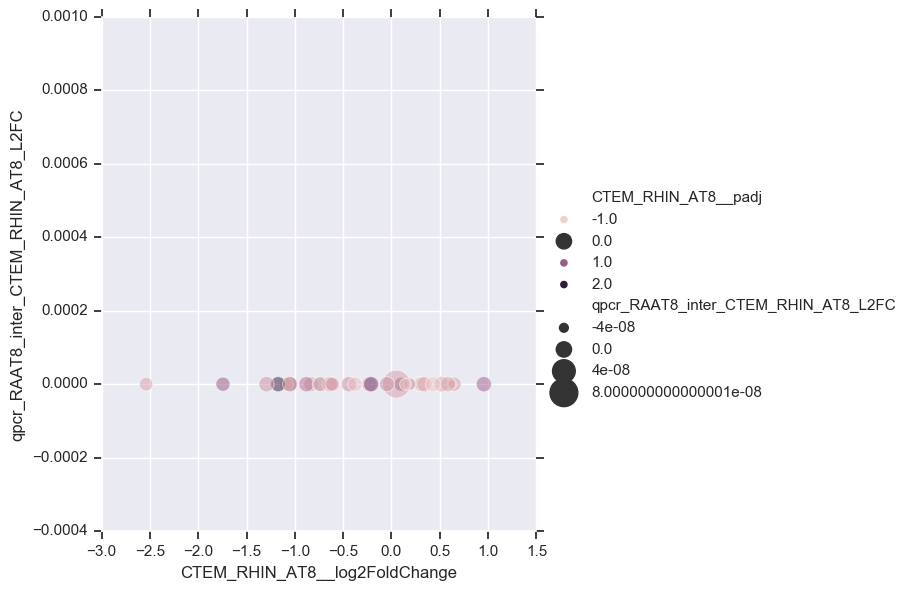

In [195]:
#fig, ax = plt.subplots(figsize=(10, 10))
#plt.subplot(2, 2, 1)
sns.relplot(x="CTEM_RHIN_AT8__log2FoldChange", y='qpcr_RAAT8_inter_CTEM_RHIN_AT8_L2FC', 
            hue="CTEM_RHIN_AT8__padj", 
            size="qpcr_RAAT8_inter_CTEM_RHIN_AT8_L2FC",
            sizes=(40, 400), alpha=.5,height=6, data=sp)
plt.ylim(-0.0004,0.001)
#plt.subplot(2, 2, 2)
#sns.relplot(x="CTES_AT8__log2FoldChange", y='qpcr_RAAT8_inter_CTES_AT8_L2FC', 
#            hue="CTES_AT8__padj", 
#            size="qpcr_RAAT8_inter_CTES_AT8_L2FC",
#            sizes=(40, 400), alpha=.5,height=6, data=sp)

#plt.subplot(2, 2, 3)
#sns.relplot(x="CTEM_RHIN_AT8__log2FoldChange", y='qpcr_AT8_inter_CTEM_RHIN_AT8_L2FC', 
#            hue="CTEM_RHIN_AT8__padj", 
#            size="qpcr_AT8_inter_CTEM_RHIN_AT8_L2FC",
#            sizes=(40, 400), alpha=.5,height=6, data=sp)
#plt.subplot(2, 2, 4)
#sns.relplot(x="CTES_AT8__log2FoldChange", y='qpcr_AT8_inter_CTES_AT8_L2FC', 
#            hue="CTES_AT8__padj", 
#            size="qpcr_AT8_inter_CTES_AT8_L2FC",
#            sizes=(40, 400), alpha=.5,height=6, data=sp)

(-1e-05, 4e-05)

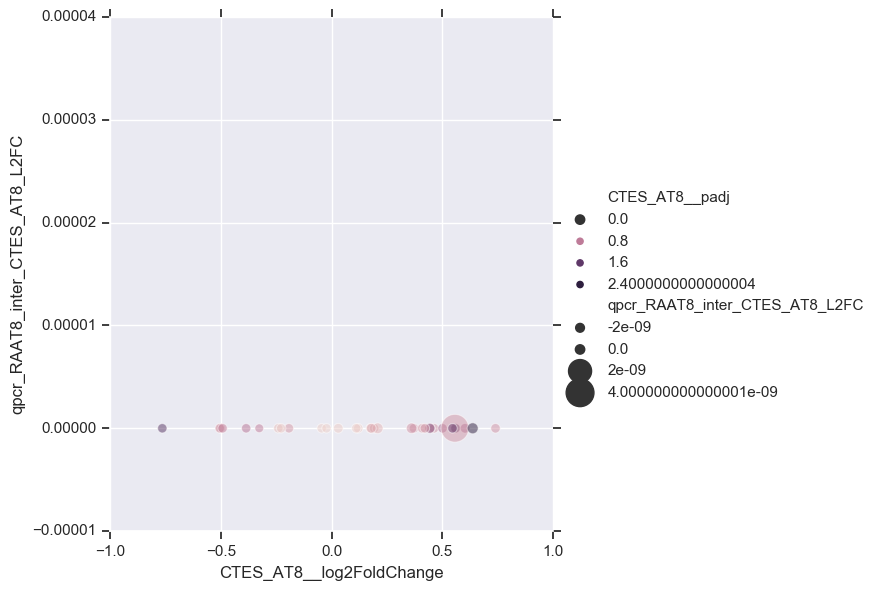

In [196]:
sns.relplot(x="CTES_AT8__log2FoldChange", y='qpcr_RAAT8_inter_CTES_AT8_L2FC', 
            hue="CTES_AT8__padj", 
            size="qpcr_RAAT8_inter_CTES_AT8_L2FC",
            sizes=(40, 400), alpha=.5,height=6, data=sp)
plt.ylim(-0.00001,0.00004)

(-0.0005, 0.0025)

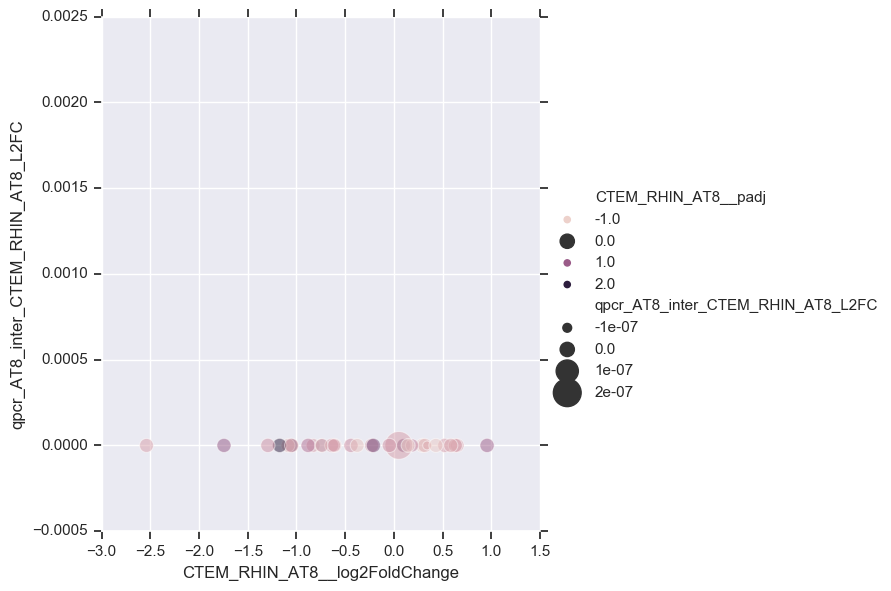

In [197]:
sns.relplot(x="CTEM_RHIN_AT8__log2FoldChange", y='qpcr_AT8_inter_CTEM_RHIN_AT8_L2FC', 
            hue="CTEM_RHIN_AT8__padj", 
            size="qpcr_AT8_inter_CTEM_RHIN_AT8_L2FC",
            sizes=(40, 400), alpha=.5,height=6, data=sp)
plt.ylim(-0.0005,0.0025)

(-1e-05, 4e-05)

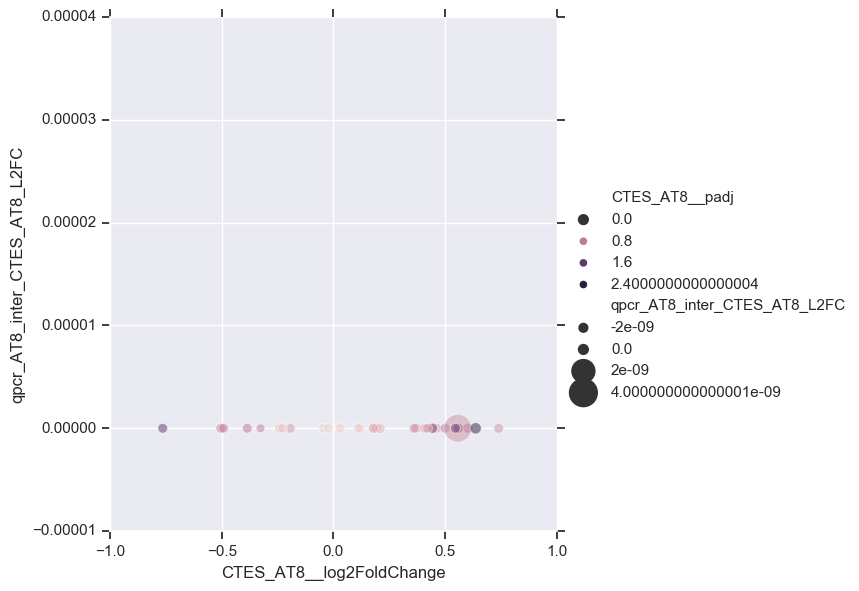

In [198]:
sns.relplot(x="CTES_AT8__log2FoldChange", y='qpcr_AT8_inter_CTES_AT8_L2FC', 
            hue="CTES_AT8__padj", 
            size="qpcr_AT8_inter_CTES_AT8_L2FC",
            sizes=(40, 400), alpha=.5,height=6, data=sp)
plt.ylim(-0.00001,0.00004)

### Confusion Matrix

In [270]:
eq = 'qpcr_RAAT8'
cm_ctem = pd.DataFrame({'qpcr':['Up','Down'], 
             'DE_UP':[len(sp[(sp['CTEM_RHIN_AT8__log2FoldChange']>0) & (sp[eq+'_inter_CTEM_RHIN_AT8_L2FC']>0)]),
                     len(sp[(sp['CTEM_RHIN_AT8__log2FoldChange']>0) & (sp[eq+'_inter_CTEM_RHIN_AT8_L2FC']<0)])],
             'DE_Down':[len(sp[(sp['CTEM_RHIN_AT8__log2FoldChange']<0) & (sp[eq+'_inter_CTEM_RHIN_AT8_L2FC']>0)]),
                     len(sp[(sp['CTEM_RHIN_AT8__log2FoldChange']<0) & (sp[eq+'_inter_CTEM_RHIN_AT8_L2FC']<0)])]}, 
             columns=['qpcr','DE_UP','DE_Down'])

cm_ctes = pd.DataFrame({'qpcr':['Up','Down'], 
                        'DE_UP':[len(sp[(sp['CTES_AT8__log2FoldChange']>0) & (sp[eq+'_inter_CTES_AT8_L2FC']>0)]),
                                 len(sp[(sp['CTES_AT8__log2FoldChange']>0) & (sp[eq+'_inter_CTES_AT8_L2FC']<0)])],
                        'DE_Down':[len(sp[(sp['CTES_AT8__log2FoldChange']<0) & (sp[eq+'_inter_CTES_AT8_L2FC']>0)]),
                                   len(sp[(sp['CTES_AT8__log2FoldChange']<0) & (sp[eq+'_inter_CTES_AT8_L2FC']<0)])]}, 
             columns=['qpcr','DE_UP','DE_Down'])

In [271]:
print(cm_ctem, '\n',cm_ctes)

   qpcr  DE_UP  DE_Down
0    Up      4        2
1  Down      9       17 
    qpcr  DE_UP  DE_Down
0    Up     21        3
1  Down      0        8


In [272]:
p = 0.05
qctr_sig = sp[(sp['CTEM_RHIN_AT8__padj'] < p) & (sp[eq+'_inter_CTEM_RHIN_AT8_pval'] < p)]
qcts_sig = sp[(sp['CTES_AT8__padj'] < p) & (sp[eq+'_inter_CTES_AT8_pval'] < p)]
print(len(qctr_sig),len(qcts_sig))

pd.DataFrame({'qpcr':['Up','Down'], 
             'DE_UP':[len(qcts_sig[(qcts_sig['CTES_AT8__log2FoldChange']>0) & (qcts_sig[eq+'_inter_CTES_AT8_L2FC']>0)]),
                     len(qcts_sig[(qcts_sig['CTES_AT8__log2FoldChange']>0) & (qcts_sig[eq+'_inter_CTES_AT8_L2FC']<0)])],
             'DE_Down':[len(qcts_sig[(qcts_sig['CTES_AT8__log2FoldChange']<0) & (qcts_sig[eq+'_inter_CTES_AT8_L2FC']>0)]),
                     len(qcts_sig[(qcts_sig['CTES_AT8__log2FoldChange']<0) & (qcts_sig[eq+'_inter_CTES_AT8_L2FC']<0)])]}, 
             columns=['qpcr','DE_UP','DE_Down'])

0 1


qpcr  DE_UP  DE_Down
0    Up      1        0
1  Down      0        0

In [273]:
pd.DataFrame({'qpcr':['Up','Down'], 
             'DE_UP':[len(qctr_sig[(qctr_sig['CTEM_RHIN_AT8__log2FoldChange']>0) & (qctr_sig[eq+'_inter_CTEM_RHIN_AT8_L2FC']>0)]),
                     len(qctr_sig[(qctr_sig['CTEM_RHIN_AT8__log2FoldChange']>0) & (qctr_sig[eq+'_inter_CTEM_RHIN_AT8_L2FC']<0)])],
             'DE_Down':[len(qctr_sig[(qctr_sig['CTEM_RHIN_AT8__log2FoldChange']<0) & (qctr_sig[eq+'_inter_CTEM_RHIN_AT8_L2FC']>0)]),
                     len(qctr_sig[(qctr_sig['CTEM_RHIN_AT8__log2FoldChange']<0) & (qctr_sig[eq+'_inter_CTEM_RHIN_AT8_L2FC']<0)])]}, 
             columns=['qpcr','DE_UP','DE_Down'])

qpcr  DE_UP  DE_Down
0    Up      0        0
1  Down      0        0

In [250]:
qctr_sig

Gene name             Name  CTEM_RHIN_AT8__log2FoldChange  \
11      MMP2  ENSG00000087245                      -0.610056   

    CTEM_RHIN_AT8__padj  CTES_AT8__log2FoldChange  CTES_AT8__padj  \
11             -0.00822                  0.500228        1.019107   

    qpcr_RAAT8_inter_CTEM_RHIN_AT8_L2FC  qpcr_RAAT8_inter_CTES_AT8_L2FC  \
11                        -3.692379e-10                    2.583561e-12   

    qpcr_AT8_inter_CTEM_RHIN_AT8_L2FC  qpcr_AT8_inter_CTES_AT8_L2FC  \
11                      -7.269491e-10                  1.952896e-12   

    qpcr_RAAT8_inter_CTEM_RHIN_AT8_pval  qpcr_RAAT8_inter_CTES_AT8_pval  \
11                             0.331288                        0.677068   

    qpcr_AT8_inter_CTEM_RHIN_AT8_pval  qpcr_AT8_inter_CTES_AT8_pval  
11                           0.032477                      0.718991

In [34]:
deat8 = pd.read_csv("all_DE_AT8_annot.csv", sep=",")
deat8.columns = [_.replace('_all_DE_AT8','') for _ in list(deat8)]
deat8_genes = deat8['Name'].head(n=20).tolist()
deat8["Gene name"].replace({"HLA-DRA": "HLA_DRA"}, inplace=True)
deat8['cat'] = pd.Categorical(deat8['Gene name'], categories=qpcr_genes, ordered=True)
cols = ['Gene name','CTEM_RHIN_baseMean','CTEM_RHIN_L2FC','CTEM_RHIN_pvalue','CTEM_RHIN_padj',
        'CTE_34_baseMean','CTE_34_L2FC','CTE_34_pvalue','CTE_34_padj','cat']
deat8 = deat8[cols]
deat8.columns = ['Gene name','CTEM_RHIN_BM','CTEM_RHIN_L2FC','CTEM_RHIN_pvalue','CTEM_RHIN_padj',
                 'CTE_34_BM','CTE_34_L2FC','CTE_34_pvalue','CTE_34_padj','cat']

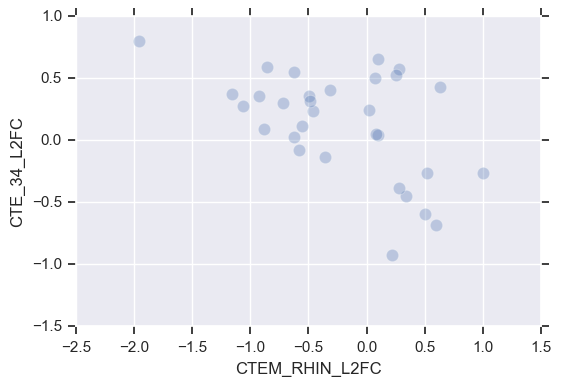

In [35]:
d = deat8[(deat8['Gene name'].isin(qpcr_genes)) & (deat8['Gene name']!='HLA_DRA')].sort_values('cat')
#sigdeat8 = deat8[(deat8['CTEM_RHIN_pvalue']<0.05)&(deat8['CTE_34_pvalue']<0.05)]
sns.scatterplot(d['CTEM_RHIN_L2FC'],d['CTE_34_L2FC'], alpha=0.3, s=80)

In [71]:
infom = pd.read_csv('../CTE_sample_info_all.csv', sep=',')
infom = infom[infom['Status']!= 'CNT']
infom['SampleName']=['{}-{:03d}'.format(_.split('-')[0], int(_.split('-')[1])) if 'SLI' in _ else _ for _ in infom['SampleName']]
infom['SampleName'] = [_.replace('-','_') for _ in infom['SampleName'].tolist()]
all_cnts = pd.read_csv('../all_wocnt_all_counts_filt_norm.csv', sep=',')
all_cnts.loc[:, ['Name']] = all_cnts['Name'].str.split('.').str[0]
ensembl = pd.read_csv("../biomart_export_grch38p12.txt", sep='\t', usecols=[0,1])
ensembl.columns = ['Name', 'Gene name']
infom = infom[infom['SampleName'].isin(inter_id)]
infom = infom[~infom['SampleName'].isin(outliers['Case'].tolist())]

#infos = infoc[infoc['Diagnosis']!='CTES']
infom = infom.set_index(['ID'])
infom = infom.sort_values('AT8')
ordered = list(infom.index)
print(len(infom))
infom.head()

plot_hm = pd.merge(ensembl, all_cnts, on='Name')
plot_hm["Gene name"].replace({"HLA-DRA": "HLA_DRA"}, inplace=True)
plot_hm = plot_hm[list(plot_hm)[1:]]
plot_hm = plot_hm.set_index('Gene name')
plot_hm = plot_hm[ordered]
plot_hm = plot_hm.T
plot_hm['Status'] = plot_hm.index.str.split('_').str[0]

sub_type = plot_hm.pop('Status')
lut = dict(zip(sub_type.unique(), ["green","yellow","purple"]))
#lut = dict(zip(sub_type.unique(), ["green","yellow"]))
col_colors = sub_type.map(lut)
plot_hm = plot_hm.T
print(len(infom))
print(lut)

52
52
{'RHIN': 'yellow', 'CTES': 'purple', 'CTEM': 'green'}


/Users/Mojito/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


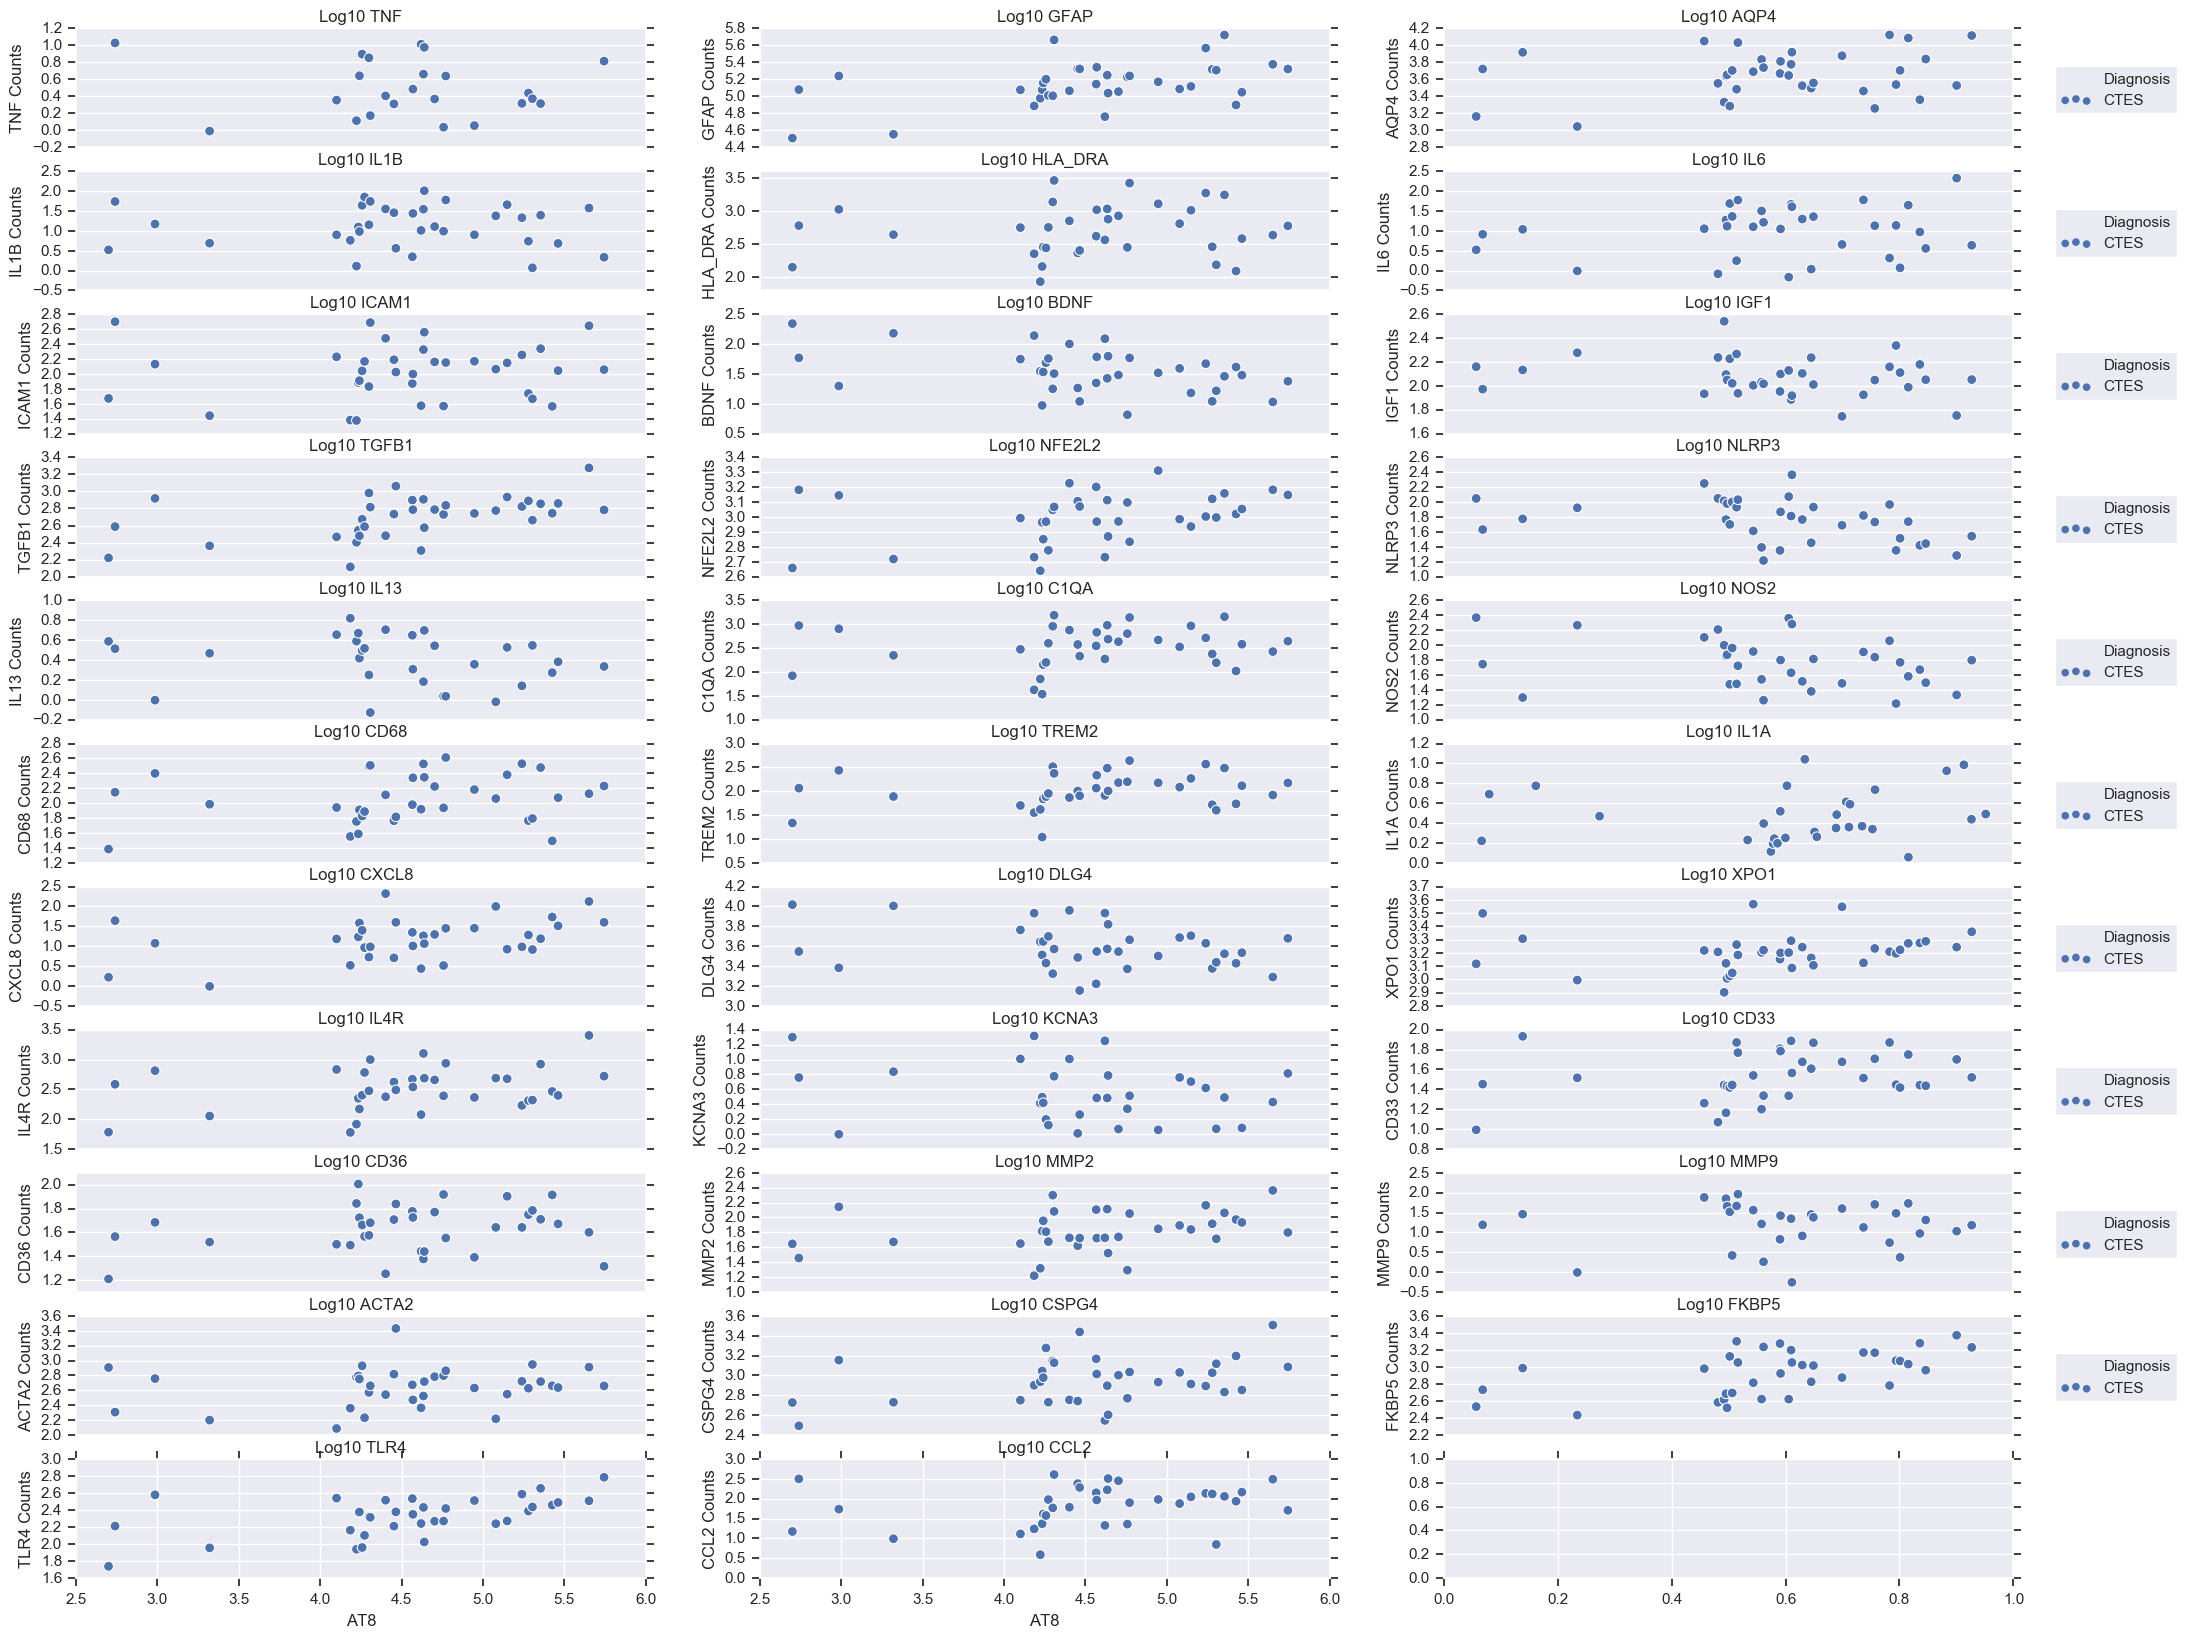

In [74]:
# reminder: toty = [ctes_ty, cmrhi_ty]
f,axs = plt.subplots(11,3, figsize=(25,20))
axs = it.chain(*[list(_) for _ in axs])

genes = [ _ for _ in qpcr_genes if 'IL10' not in _ and 'IFNG' not in _]

for i, (gene,ax) in enumerate(zip(genes, axs)):
    a = pd.merge(plot_hm.T[[gene]], infom[['AT8','Diagnosis']], left_index=True, right_index=True)
    a[gene] = np.log10(a[gene])
    a = a.replace(-np.Inf, np.nan)
    a = a[['CTES' in s for s in a.index]]
    sns.scatterplot(x='AT8', y=gene, data=a, hue='Diagnosis', s=50, ax=ax)
    ax.set_ylabel(gene + ' Counts')
    ax.set_title('Log10 ' + gene, fontsize=12)
    ax.legend(bbox_to_anchor=(1.3, 0.75))
    if i < 30:
        ax.get_xaxis().set_visible(False)
    if i not in [2,5,8,11,14,17,20,23,26,29,32]:
        ax.legend().set_visible(False)
#next(axs).axis('off')
plt.savefig('qpcr_matching_CS_at8.png', bbox_inches='tight')

In [99]:
f = pd.read_csv("CTES_CTEM_RHIN_intrmod_AT8_deseq2_padj.csv", sep=",")
f.loc[:, ['Name']] = f['Name'].str.split('.').str[0]
f["Gene name"].replace({"HLA-DRA": "HLA_DRA"}, inplace=True)
s = f[f['WaldPvalue_groupCTES.AT8']<0.05]
#print(len(s[s['WaldStatistic_groupCTES.AT8']<0]),len(s[s['WaldStatistic_groupCTES.AT8']>0]))

ensembl = pd.read_csv("biomart_export_grch38p12.txt", sep='\t', usecols=[0,1])
ensembl.columns = ['Name', 'Gene name']
f = pd.merge(ensembl,f, on=['Name','Gene name'])

print(f.columns)

/Users/Mojito/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['Name', 'Gene name', 'baseMean', 'baseVar', 'allZero', 'dispGeneEst',
       'dispGeneIter', 'dispFit', 'dispersion', 'dispIter', 'dispOutlier',
       'dispMAP', 'Intercept', 'group_CTES_vs_CTEM_RHIN', 'AT8',
       'groupCTES.AT8', 'SE_Intercept', 'SE_group_CTES_vs_CTEM_RHIN', 'SE_AT8',
       'SE_groupCTES.AT8', 'WaldStatistic_Intercept',
       'WaldStatistic_group_CTES_vs_CTEM_RHIN', 'WaldStatistic_AT8',
       'WaldStatistic_groupCTES.AT8', 'WaldPvalue_Intercept',
       'WaldPvalue_group_CTES_vs_CTEM_RHIN', 'WaldPvalue_AT8',
       'WaldPvalue_groupCTES.AT8', 'betaConv', 'betaIter', 'deviance',
       'maxCooks', 'WaldPadj_Intercept', 'WaldPadj_group_CTES_vs_CTEM_RHIN',
       'WaldPadj_AT8', 'WaldPadj_groupCTES.AT8'],
      dtype='object')


In [102]:
#f.sort_values('WaldPvalue_groupCTES.AT8')[['Gene name','Name','baseMean','AT8','groupCTES.AT8','group_CTES_vs_CTEM_RHIN','WaldPvalue_groupCTES.AT8']]
print(qpcr_genes)

['TNF', 'GFAP', 'AQP4', 'IL1B', 'HLA_DRA', 'IL6', 'ICAM1', 'BDNF', 'IGF1', 'TGFB1', 'IL10', 'NFE2L2', 'NLRP3', 'IL13', 'C1QA', 'NOS2', 'CD68', 'TREM2', 'IFNG', 'IL1A', 'CXCL8', 'DLG4', 'XPO1', 'IL4R', 'KCNA3', 'CD33', 'CD36', 'MMP2', 'MMP9', 'ACTA2', 'CSPG4', 'FKBP5', 'TLR4', 'CCL2']


In [101]:
#f_at8 = f[f['Name'].isin(deat8_genes)].copy()
f_at8 = f[f['Gene name'].isin(qpcr_genes)].copy()
#f_at8['cat'] = pd.Categorical(f_at8['Name'], categories=deat8_genes, ordered=True)
f_at8['cat'] = pd.Categorical(f_at8['Gene name'], categories=qpcr_genes, ordered=True)
#sorterIndex = dict(zip(sorter,range(len(sorter))))
cols = ['Gene name','baseMean','AT8','groupCTES.AT8','group_CTES_vs_CTEM_RHIN','WaldPvalue_groupCTES.AT8','cat']
f_at8[cols].sort_values('cat')


Gene name       baseMean       AT8  groupCTES.AT8  \
30331       TNF       2.349950  0.311809      -0.425424   
25109      GFAP  140709.077127  0.589983       0.060180   
26853      AQP4    5134.960535  0.691972      -0.277104   
17085      IL1B      23.175523 -1.520327       1.446046   
5400        IL6      20.189616 -1.498863       2.274002   
4983      ICAM1     124.443151 -0.530343       0.636085   
26623      BDNF      75.909929 -0.528496      -0.437724   
7565       IGF1     144.507563 -0.286541       0.176828   
31181     TGFB1     498.486661 -0.453301       0.941213   
29068    NFE2L2     906.854134  0.063733       0.186693   
15849     NLRP3      80.845584  0.154759      -0.616450   
21310      IL13       2.376160 -0.346853       0.095599   
27242      C1QA     452.733585 -0.812178       0.949330   
27428      NOS2     112.405816 -0.420558      -0.250430   
29209      CD68     145.332126 -0.793336       1.235794   
13099     TREM2     134.920682 -0.681130       1.022922   
16893      IL1A       3.001920 -1.529373       1.532527   
17234     CXCL8      21.411062 -1.429155       1.894123   
26202      DLG4    5902.721224 -0.345072      -0.066457   
1779       XPO1    1639.981431 -0.171853       0.221301   
6417       IL4R     380.971863 -0.604260       1.119690   
22755     KCNA3       7.294450 -0.285245      -0.452297   
18699      CD33      37.186857 -0.618688       0.922903   
14095      CD36      43.857839  0.085479       0.187795   
16558      MMP2      72.587711 -0.692567       0.966986   
28913      MMP9      20.040368 -1.005844       1.386761   
16140     ACTA2     545.544422  0.048528       0.061168   
28828     CSPG4     879.629389 -0.010128       0.359284   
28947     FKBP5     775.265309  0.413778       0.076516   
6131       TLR4     212.743193  0.207547       0.267142   
5150       CCL2     120.381445 -0.564122       1.199219   

       group_CTES_vs_CTEM_RHIN  WaldPvalue_groupCTES.AT8     cat  
30331                 1.735502                  0.586693     TNF  
25109                 0.713924                  0.880332    GFAP  
26853                 1.124369                  0.492508    AQP4  
17085                -4.045297                  0.048020    IL1B  
5400                 -7.135287                  0.009047     IL6  
4983                 -0.750915                  0.204384   ICAM1  
26623                 1.419799                  0.321847    BDNF  
7565                 -0.777641                  0.441371    IGF1  
31181                -2.531924                  0.004437   TGFB1  
29068                -0.164115                  0.487356  NFE2L2  
15849                 2.071117                  0.059378   NLRP3  
21310                -0.007341                  0.834581    IL13  
27242                -1.617879                  0.063171    C1QA  
27428                 0.660970                  0.556140    NOS2  
29209                -2.746065                  0.011563    CD68  
13099                -2.306913                  0.028329   TREM2  
16893                -3.990933                  0.019980    IL1A  
17234                -4.962159                  0.002435   CXCL8  
26202                -0.043255                  0.814253    DLG4  
1779                 -0.485124                  0.275987    XPO1  
6417                 -3.390347                  0.027519    IL4R  
22755                 0.920993                  0.386266   KCNA3  
18699                -2.278031                  0.013120    CD33  
14095                -0.618376                  0.507538    CD36  
16558                -2.561078                  0.007646    MMP2  
28913                -2.978857                  0.123671    MMP9  
16140                 0.335241                  0.869307   ACTA2  
28828                -0.869700                  0.204304   CSPG4  
28947                 0.363993                  0.822608   FKBP5  
6131                 -0.677793                  0.434180    TLR4  
5150                 -3.562666          

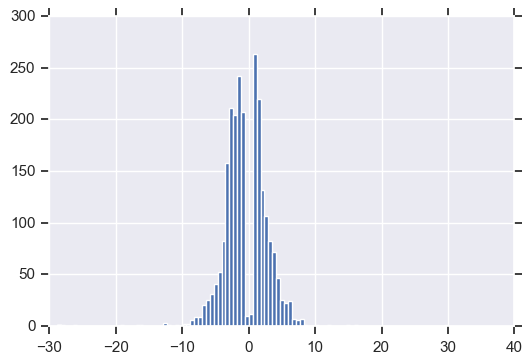

In [298]:
s['group_CTES_vs_CTEM_RHIN'].hist(bins=100)

In [50]:
df = pd.read_csv("all_DE_AT8_annot.csv", sep=",")
df = df[~df['CTE_34_all_DE_AT8_L2FC'].isnull()]
df = df[~df['CTEM_RHIN_all_DE_AT8_L2FC'].isnull()]
df = df[~df['CTE_34_all_DE_AT8_pvalue'].isnull()]
df = df[~df['CTEM_RHIN_all_DE_AT8_pvalue'].isnull()]
df = df[~df['CTE_34_all_DE_AT8_padj'].isnull()]
df = df[~df['Gene name'].isnull()]
df = df[~df['CTEM_RHIN_all_DE_AT8_padj'].isnull()]
df = df.drop_duplicates('Gene name',keep='first')

In [51]:
df.columns

Index(['Gene name', 'Name', 'CTES_CTEM_all_DE_AT8_baseMean',
       'CTES_CTEM_all_DE_AT8_L2FC', 'CTES_CTEM_all_DE_AT8_lfcSE',
       'CTES_CTEM_all_DE_AT8_stat', 'CTES_CTEM_all_DE_AT8_pvalue',
       'CTES_CTEM_all_DE_AT8_padj', 'CTEM_RHIN_all_DE_AT8_baseMean',
       'CTEM_RHIN_all_DE_AT8_L2FC', 'CTEM_RHIN_all_DE_AT8_lfcSE',
       'CTEM_RHIN_all_DE_AT8_stat', 'CTEM_RHIN_all_DE_AT8_pvalue',
       'CTEM_RHIN_all_DE_AT8_padj', 'CTE_34_all_DE_AT8_baseMean',
       'CTE_34_all_DE_AT8_L2FC', 'CTE_34_all_DE_AT8_lfcSE',
       'CTE_34_all_DE_AT8_stat', 'CTE_34_all_DE_AT8_pvalue',
       'CTE_34_all_DE_AT8_padj', 'all_wocnt_all_DE_AT8_baseMean',
       'all_wocnt_all_DE_AT8_L2FC', 'all_wocnt_all_DE_AT8_lfcSE',
       'all_wocnt_all_DE_AT8_stat', 'all_wocnt_all_DE_AT8_pvalue',
       'all_wocnt_all_DE_AT8_padj', 'CTES_RHIN_all_DE_AT8_baseMean',
       'CTES_RHIN_all_DE_AT8_L2FC', 'CTES_RHIN_all_DE_AT8_lfcSE',
       'CTES_RHIN_all_DE_AT8_stat', 'CTES_RHIN_all_DE_AT8_pvalue',
       'CTES_RHI

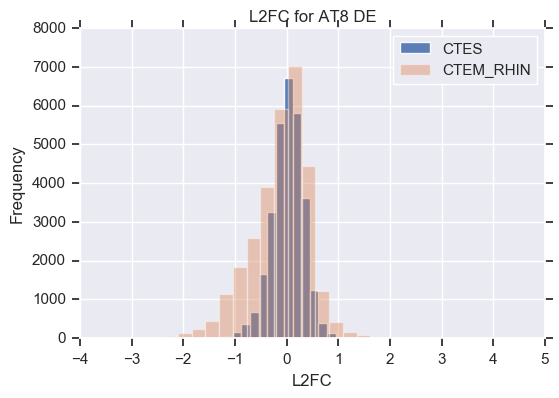

In [52]:
b = 30
plt.hist(df['CTE_34_all_DE_AT8_L2FC'],alpha=0.9, label='CTES', bins=b)
plt.hist(df['CTEM_RHIN_all_DE_AT8_L2FC'],alpha=0.4, label='CTEM_RHIN',bins=b)
plt.legend(loc='upper right')
plt.xlabel('L2FC')
plt.ylabel('Frequency')
plt.title('L2FC for AT8 DE')

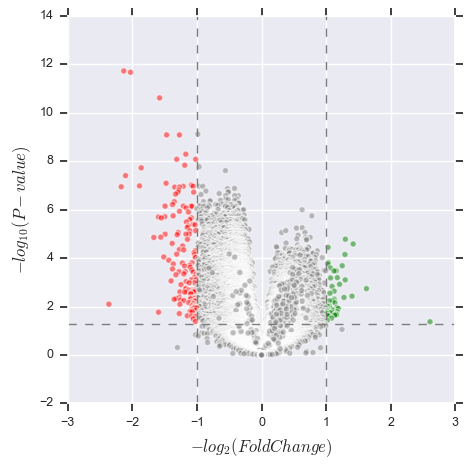

In [53]:
from bioinfokit import visuz

visuz.gene_exp.volcano(df, lfc='CTE_34_all_DE_AT8_L2FC', pv='CTE_34_all_DE_AT8_padj',
                       show=True,dotsize=20,sign_line=True,valpha=0.5)

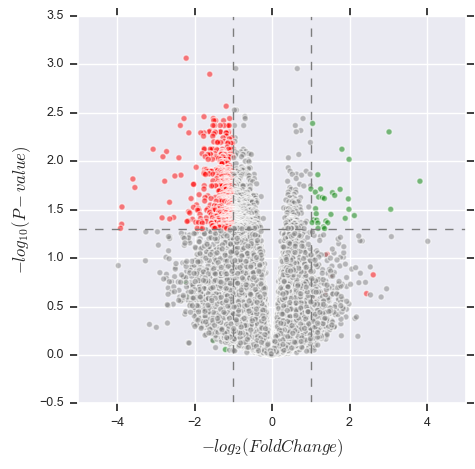

In [54]:
visuz.gene_exp.volcano(df, lfc='CTEM_RHIN_all_DE_AT8_L2FC', pv='CTEM_RHIN_all_DE_AT8_padj',
                       show=True,dotsize=20,valpha=0.5,sign_line=True)

In [58]:
-np.log10(0.05)

1.3010299956639813